#### Fit for the BBH population with GWTC-3, parameterizing redshift distribution as formation redshift distribution + delay times

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.infer import MCMC, NUTS

import h5py

import corner

from jax.scipy.special import erf as scipy_erf

import sys
try:
    sys.path.index('/Users/mayafishbach/Desktop/GWTC3')
except ValueError:
    sys.path.append('/Users/mayafishbach/Desktop/GWTC3')
    
import numpyro_sample
import setup_injections_PE

### Cosmology helper functions

In [2]:
import astropy.units as u
from astropy.cosmology import Planck15

#cosmology helper functions to convert between redshift and lookback time
#zmax is the maximum redshift considered in any analysis 

zmax_i = 20
zs_i = jnp.linspace(0, zmax_i, 1000)
tLs_i = Planck15.lookback_time(zs_i).to(u.Gyr).value
tL_at_z_interp = lambda z: jnp.interp(z, zs_i, tLs_i)
z_at_tL_interp = lambda t: jnp.interp(t, tLs_i, zs_i)

### Read in injections and PE

In [3]:
default_PE_settings = {
        'dir_O3a' : "/Users/mayafishbach/Desktop/O3samples/O3a/",
        'dir_O3a_p1' : "/Users/mayafishbach/Desktop/O3samples/O3a-p1/",
        'dir_O3b': "/Users/mayafishbach/Desktop/O3samples/O3b/",
        'dir_O2' :  "/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/",  
        'exclude' : ['GW170817', 'GW190425', 'GW190814', 'GW190426', 'GW190909', 'GW190514_065416', 'GW190917', 'GW200105', 'GW200115', 'GW200220_061928', "GW191113_071753", "GW191126_115259", "GW191204_110529", "GW191219_163120", "GW200208_222617", "GW200210_092254", "GW200220_061928", "GW200220_124850", "GW200306_093714", "GW200308_173609", "GW200322_091133"],
        'spin' :  'eff',
        'nsamples' : 1000 
        }

default_injection_settings = {
        'fname' : '/Users/mayafishbach/Desktop/O3samples/injections/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5',
        'ifar_thresh' : 1.0,
        'snr_thresh' : 10.0,
        'spin' : 'eff',
        'return_pdraw_dz' : 'True'
        }

inj, Ndraw,  Tobs_years, logpdraw_dz = setup_injections_PE.preprocess_injections(**default_injection_settings)
PEsamples = setup_injections_PE.preprocess_PE(**default_PE_settings)

/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170729_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW151226_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170809_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170104_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170608_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170814_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW151012_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170818_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW150914_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/GW170823_GWTC-1.hdf5
/Users/mayafishbach/Desktop/O3samples/O3a/GW190413_052954.h5
/Users/mayafishbach/Desktop/O3samples/O3a/GW190728_064510.h5
/Users/mayafishbach/Desktop/O3samples/O3a/GW190412.h5
/Users/mayafis

In [4]:
PEsamples = np.array(PEsamples)
nevts = PEsamples.shape[0]

### Define the population model

In [5]:
####BANDPASSED POWER LAW + PEAK IN m1########
##first define a power law + peak with sharp edges
##then bandpass

def powerlaw_logmdist(m, mmin, mmax, alpha):
    return jnp.where((m >= mmin) & (m <= mmax), alpha * jnp.log(m) +  jnp.log( (alpha+1) / (mmax**(alpha+1) - mmin**(alpha+1)) ), np.NINF)

def powerlawpeak_logmdist(m, alpha1, fpeak, mupeak, sigpeak, mmin, mmax):
    pl = jnp.log(1 - fpeak) + powerlaw_logmdist(m, mmin, mmax, alpha1)
    peak = jnp.log(fpeak) + numpyro.distributions.Normal(mupeak, sigpeak).log_prob(m)
    return jnp.logaddexp(pl,peak)

def logpareto(m, scale, exp):
    return exp*(jnp.log(m) - jnp.log(scale))

def pareto(m, scale, exp):
    return (m/scale)**exp

def loghighpass(m, scale, exp):
    return logpareto(m, scale, exp) - jnp.log(1+pareto(m, scale, exp))

def loglowpass(m, scale, exp):
    return -jnp.log(1+pareto(m, scale, exp))

def bandpass_powerlawpeak_logmdist(m, mmin, mmax, alpha1, fpeak, mupeak, sigpeak, n1, n2):
    plp = powerlawpeak_logmdist(m, alpha1, fpeak, mupeak, sigpeak, 3, 100) #with sharp edges
    return plp + loghighpass(m, mmin, n1) + loglowpass(m, mmax, n2)

In [6]:
###truncated Gaussian to use for chi_eff
def truncnorm_logdist(x, mean, sigma, low = -1, high = 1):
    z = (x - mean)/sigma
    endp_low = (low - mean)/sigma
    endp_high = (high - mean)/sigma
    norm_low = 0.5* (1 + scipy_erf(endp_low/jnp.sqrt(2)))
    norm_high = 0.5 * (1 + scipy_erf(endp_high/jnp.sqrt(2)))
    norm_fac = norm_high - norm_low
    in_bounds = -jnp.log(sigma) -0.5 * z**2 - 0.5 * jnp.log(2 * np.pi) - jnp.log(norm_fac)
    return jnp.where((x<=high)&(x>=low), in_bounds, np.NINF)

In [7]:
###rate as a function of redshift

def redshift_peak(z, a, b, zp, zmax):
    '''
    Madau-like redshift distribution
    a: low redshift is approximately (1 + z)^a
    b: high redshift is approximately (1 + z)^-b
    zp: approximate peak redshift
    zmax: maximum redshift
    '''
    return jnp.where((z <= zmax) & (z >= 0), (1.0+(1.0+zp)**(-a-b))*(1+z)**a/(1.0+((1.0+z)/(1.0+zp))**(a+b)), 0)

def rate_z_merge(zm, a, b, zp, zmax, tau):
    '''
    compute rate at merger redshifts zm, scalar or of same size as tau
    assuming formation redshift follows redshift_peak(zf, a, b, zp, zmax)
    and delay time samples tau, scalar or of same size as zm 
    '''
    tm = tL_at_z_interp(zm) #lookback time at merger
    tf = tm + tau #lookback time at formation 
    zf = z_at_tL_interp(tf) #redshift at formation
    return redshift_peak(zf, a, b, zp, zmax)
    

In [8]:
default_params = [5, 50, -2.3, 0.01, 33, 3, 10, 10, 2, 3, 3, 3, 15, 0, 0.3]

class mass_redshift_spin_dist(object):
    
    _m1params = ['mmin', 'mmax', 'alpha1', 'fpeak', 'mupeak', 'sigpeak', 'n1', 'n2']
    
    _m2params = ['beta']
    
    _zparams = ['a', 'b', 'zp', 'zmax']
    
    _chiparams = ['mu', 'sig']
    
    def __init__(self, mmin, mmax, alpha1, fpeak, mupeak, sigpeak, n1, n2, beta, a, b, zp, zmax, mu, sig):
        
        self._params = self._m1params + self._m2params + self._zparams + self._chiparams
        
        self._mmin = mmin
        self._mmax = mmax
        self._alpha1 = alpha1
        self._fpeak = fpeak
        self._mupeak = mupeak
        self._sigpeak = sigpeak
        self._n1 = n1
        self._n2 = n2
        
        self._beta = beta
        
        self._a = a
        self._b = b
        self._zp = zp
        self._zmax = zmax
        
        self._mu = mu
        self._sig = sig
        
    def params(self):
        return [getattr(self, param) for param in self._params]
    
    @property
    def mmin(self):
        return self._mmin
    
    @property
    def mmax(self):
        return self._mmax
    
    @property
    def alpha1(self):
        return self._alpha1
    
    @property
    def fpeak(self):
        return self._fpeak
    
    @property
    def mupeak(self):
        return self._mupeak
    
    @property
    def sigpeak(self):
        return self._sigpeak
    
    @property
    def n1(self):
        return self._n1
    
    @property
    def n2(self):
        return self._n2
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b
    
    @property
    def zp(self):
        return self._zp
    
    @property
    def zmax(self):
        return self._zmax
    
    @property
    def mu(self):
        return self._mu
    
    @property
    def sig(self):
        return self._sig
    
    def update(self, param_dict):
        '''param_dict: key value pairs corresponding to parameter name, parameter value'''
        for p in param_dict:
            setattr(self, '_'+p, param_dict[p])
            
    def logm1dist(self, m1):
        return bandpass_powerlawpeak_logmdist(m1, self.mmin, self.mmax, self.alpha1, self.fpeak, self.mupeak, self.sigpeak, self.n1, self.n2)
    
    def logm1norm(self, m1_grid):
        return jnp.log(jnp.trapz(jnp.exp(self.logm1dist(m1_grid)), m1_grid))
    
    def logm2dist(self, m1, m2):
        return powerlaw_logmdist(m2, 3.0, m1, self.beta)
    
    def logm2norm(self):
        return 0
    
    def logzdist(self, z, tau):
        '''rate dN/dVcdt at merger redshift z'''
        return jnp.log(rate_z_merge(z, self.a, self.b, self.zp, self.zmax, tau))
    
    def logdNdzdist(self, z, tau, z_grid, dVcdz_grid):
        '''dN/dz at merger redshift z = dN/dVcdt * (1+z)^-1 * dVc/dz'''
        return self.logzdist(z, tau) - jnp.log(1 + z) + jnp.log(jnp.interp(z, z_grid, dVcdz_grid))
    
    def logdNdznorm(self, logtau_grid, ptau_grid, dlogtau, z_grid, dVcdz_grid):
        '''here logtau_grid and ptau_grid describe the pdf p(delay times) that the taus are usually drawn from
        logtau grid is logspaced with spacing dlogtau'''
        zmerge = z_grid[:, jnp.newaxis] #elevate to a 2d array, now zmerge + logtau_grid has shape (len(z_grid), len(logtau_grid))
        
        Rzmerge_array = jnp.exp(self.logzdist(zmerge, tau_grid)) #has shape (len(z_grid), len(logtau_grid))
        
        Rzmerge = jnp.inner(Rzmerge_array, logtau_grid*ptau_grid*dlogtau) #integrate over taus, has shape len(z_grid)
        
        dNdzmerge = jnp.exp(jnp.log(Rzmerge) - jnp.log(1 + z_grid) + jnp.log(dVcdz_grid)) #now setup integrand over z_grid
        
        return jnp.log(jnp.trapz(dNdzmerge, z_grid))
    
    def logchidist(self, chi_eff): 
        return truncnorm_logdist(chi_eff, self.mu, self.sig, low = -1, high = 1)
    
    def logchinorm(self):
        return 0
            
    def logprob(self, m1, m2, z, chi_eff, tau):
        '''rate dN / dVc dt dm1 dm2 dchi_eff evaluated at merger redshift z, m1, m2, chi_eff'''
        return self.logm1dist(m1) + self.logm2dist(m1, m2) + self.logzdist(z, tau) + self.logchidist(chi_eff)
    
    def logdNdzprob(self, m1, m2, z, chi_eff, z_grid, dVcdz_grid, tau):
        '''number density dN/ dz dm1 dm2 dchi_eff evaluated at merger redshift z, m1, m2, chi_eff'''
        return self.logm1dist(m1) + self.logm2dist(m1, m2) + self.logchidist(chi_eff) + self.logdNdzdist(z, tau, z_grid, dVcdz_grid)
    
    def lognorm(self, m1_grid, m2_grid, chi_grid, z_grid, dVcdz_grid, logtau_grid, ptau_grid, dlogtau):
        return self.logm1norm(m1_grid) + self.logdNdznorm(logtau_grid, ptau_grid, dlogtau, z_grid, dVcdz_grid)

### Define prior and posterior

In [14]:
def prior():
    
    hparams = dict()
    
    hparams['mmin'] = numpyro.sample('mmin', numpyro.distributions.Uniform(low = 3, high = 12))
    hparams['mmax'] = numpyro.sample('mmax', numpyro.distributions.Uniform(low = 40, high = 80))
    hparams['alpha1'] = numpyro.sample('alpha1', numpyro.distributions.Uniform(low = -8, high = -0.5))
    hparams['fpeak'] = numpyro.sample('fpeak', numpyro.distributions.Uniform(low = 0.001, high = 0.3))
    hparams['mupeak'] = numpyro.sample('mupeak', numpyro.distributions.Uniform(low = 25, high = 50))
    hparams['sigpeak'] = numpyro.sample('sigpeak', numpyro.distributions.Uniform(low = 2, high = 8))
    hparams['n1'] = numpyro.sample('n1', numpyro.distributions.Uniform(low = 1, high = 20))
    hparams['n2'] = numpyro.sample('n2', numpyro.distributions.Uniform(low = 1, high = 20))
    
    hparams['beta'] = numpyro.sample('beta', numpyro.distributions.Uniform(low = -2, high = 8))
    
    hparams['a'] = numpyro.sample('a', numpyro.distributions.Uniform(low = 0, high = 8))
    hparams['b'] = numpyro.sample('b', numpyro.distributions.Uniform(low = 0, high = 8))
    hparams['zp'] = numpyro.sample('zp', numpyro.distributions.Uniform(low = 0.5, high = 6))
    hparams['zmax'] = numpyro.sample('zmax', numpyro.distributions.Uniform(low = 10, high = 20))

    hparams['mu'] = numpyro.sample('mu', numpyro.distributions.Uniform(low = -0.5, high = 0.5))
    hparams['sig'] = numpyro.sample('sig', numpyro.distributions.Uniform(low = 0.03, high = 0.5))

    return hparams

tmin = 0.05

logtau_dist = numpyro.distributions.Uniform(low = jnp.log(tmin), high = jnp.log(tLs_i[-1])) #assume flat in log distribution for p(tau), note we can also put a prior on the slope and tmin

logtaus = logtau_dist.sample(random.PRNGKey(0), sample_shape = (PEsamples.shape[0], PEsamples.shape[1])) #same shape as PE samples 

logtaus_inj = logtau_dist.sample(random.PRNGKey(0), sample_shape = inj[:,0].shape) #same shape as injections

taus = jnp.exp(logtaus)
taus_inj = jnp.exp(logtaus_inj)

def posterior():    
    
    #logtaus = numpyro.sample('logtaus', logtau_dist, sample_shape = (PEsamples.shape[0], PEsamples.shape[1])) #same shape as PE samples 
    #taus = numpyro.deterministic('taus', jnp.exp(logtaus))
    
    #logtaus_inj = numpyro.sample('logtaus_inj', logtau_dist, sample_shape = inj[:,0].shape)
    #taus_inj = numpyro.deterministic('taus_inj', jnp.exp(logtaus_inj))
    
    loglike, Pdet, Neff = numpyro_sample.log_likelihood_Pdet_Neff(mass_redshift_spin_dist(**prior()), PEsamples, inj, Ndraw, taus, taus_inj)
    
    numpyro.factor('loglikelihood', loglike)
    numpyro.deterministic('Pdet', Pdet)
    numpyro.deterministic('Neff', Neff)

### Sample from posterior

In [16]:
sampler = MCMC(NUTS(posterior), num_warmup=2000, num_samples=2000, progress_bar = True)

sampler.run(random.PRNGKey(0))

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [15:33<00:00,  4.29it/s, 15 steps of size 2.64e-01. acc. prob=0.91]


In [18]:
samples = sampler.get_samples()
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      5.50      1.58      5.67      3.30      8.00   1769.24      1.00
    alpha1     -3.39      0.41     -3.38     -4.01     -2.70   1134.39      1.00
         b      4.45      2.15      4.64      1.29      7.91   2489.67      1.00
      beta      2.51      1.44      2.25      0.35      4.86   1209.54      1.00
     fpeak      0.02      0.01      0.01      0.00      0.03   1140.75      1.00
      mmax     66.96     10.59     70.07     48.98     80.00   1332.99      1.00
      mmin      8.07      0.92      8.15      6.65      9.57   1452.28      1.00
        mu      0.05      0.02      0.05      0.03      0.08   2309.12      1.00
    mupeak     34.62      1.12     34.62     33.05     36.53   1535.26      1.00
        n1     14.53      3.85     15.15      8.91     20.00   2590.59      1.00
        n2      7.76      5.73      6.10      1.00     16.96   1685.92      1.00
       sig      0.09      0

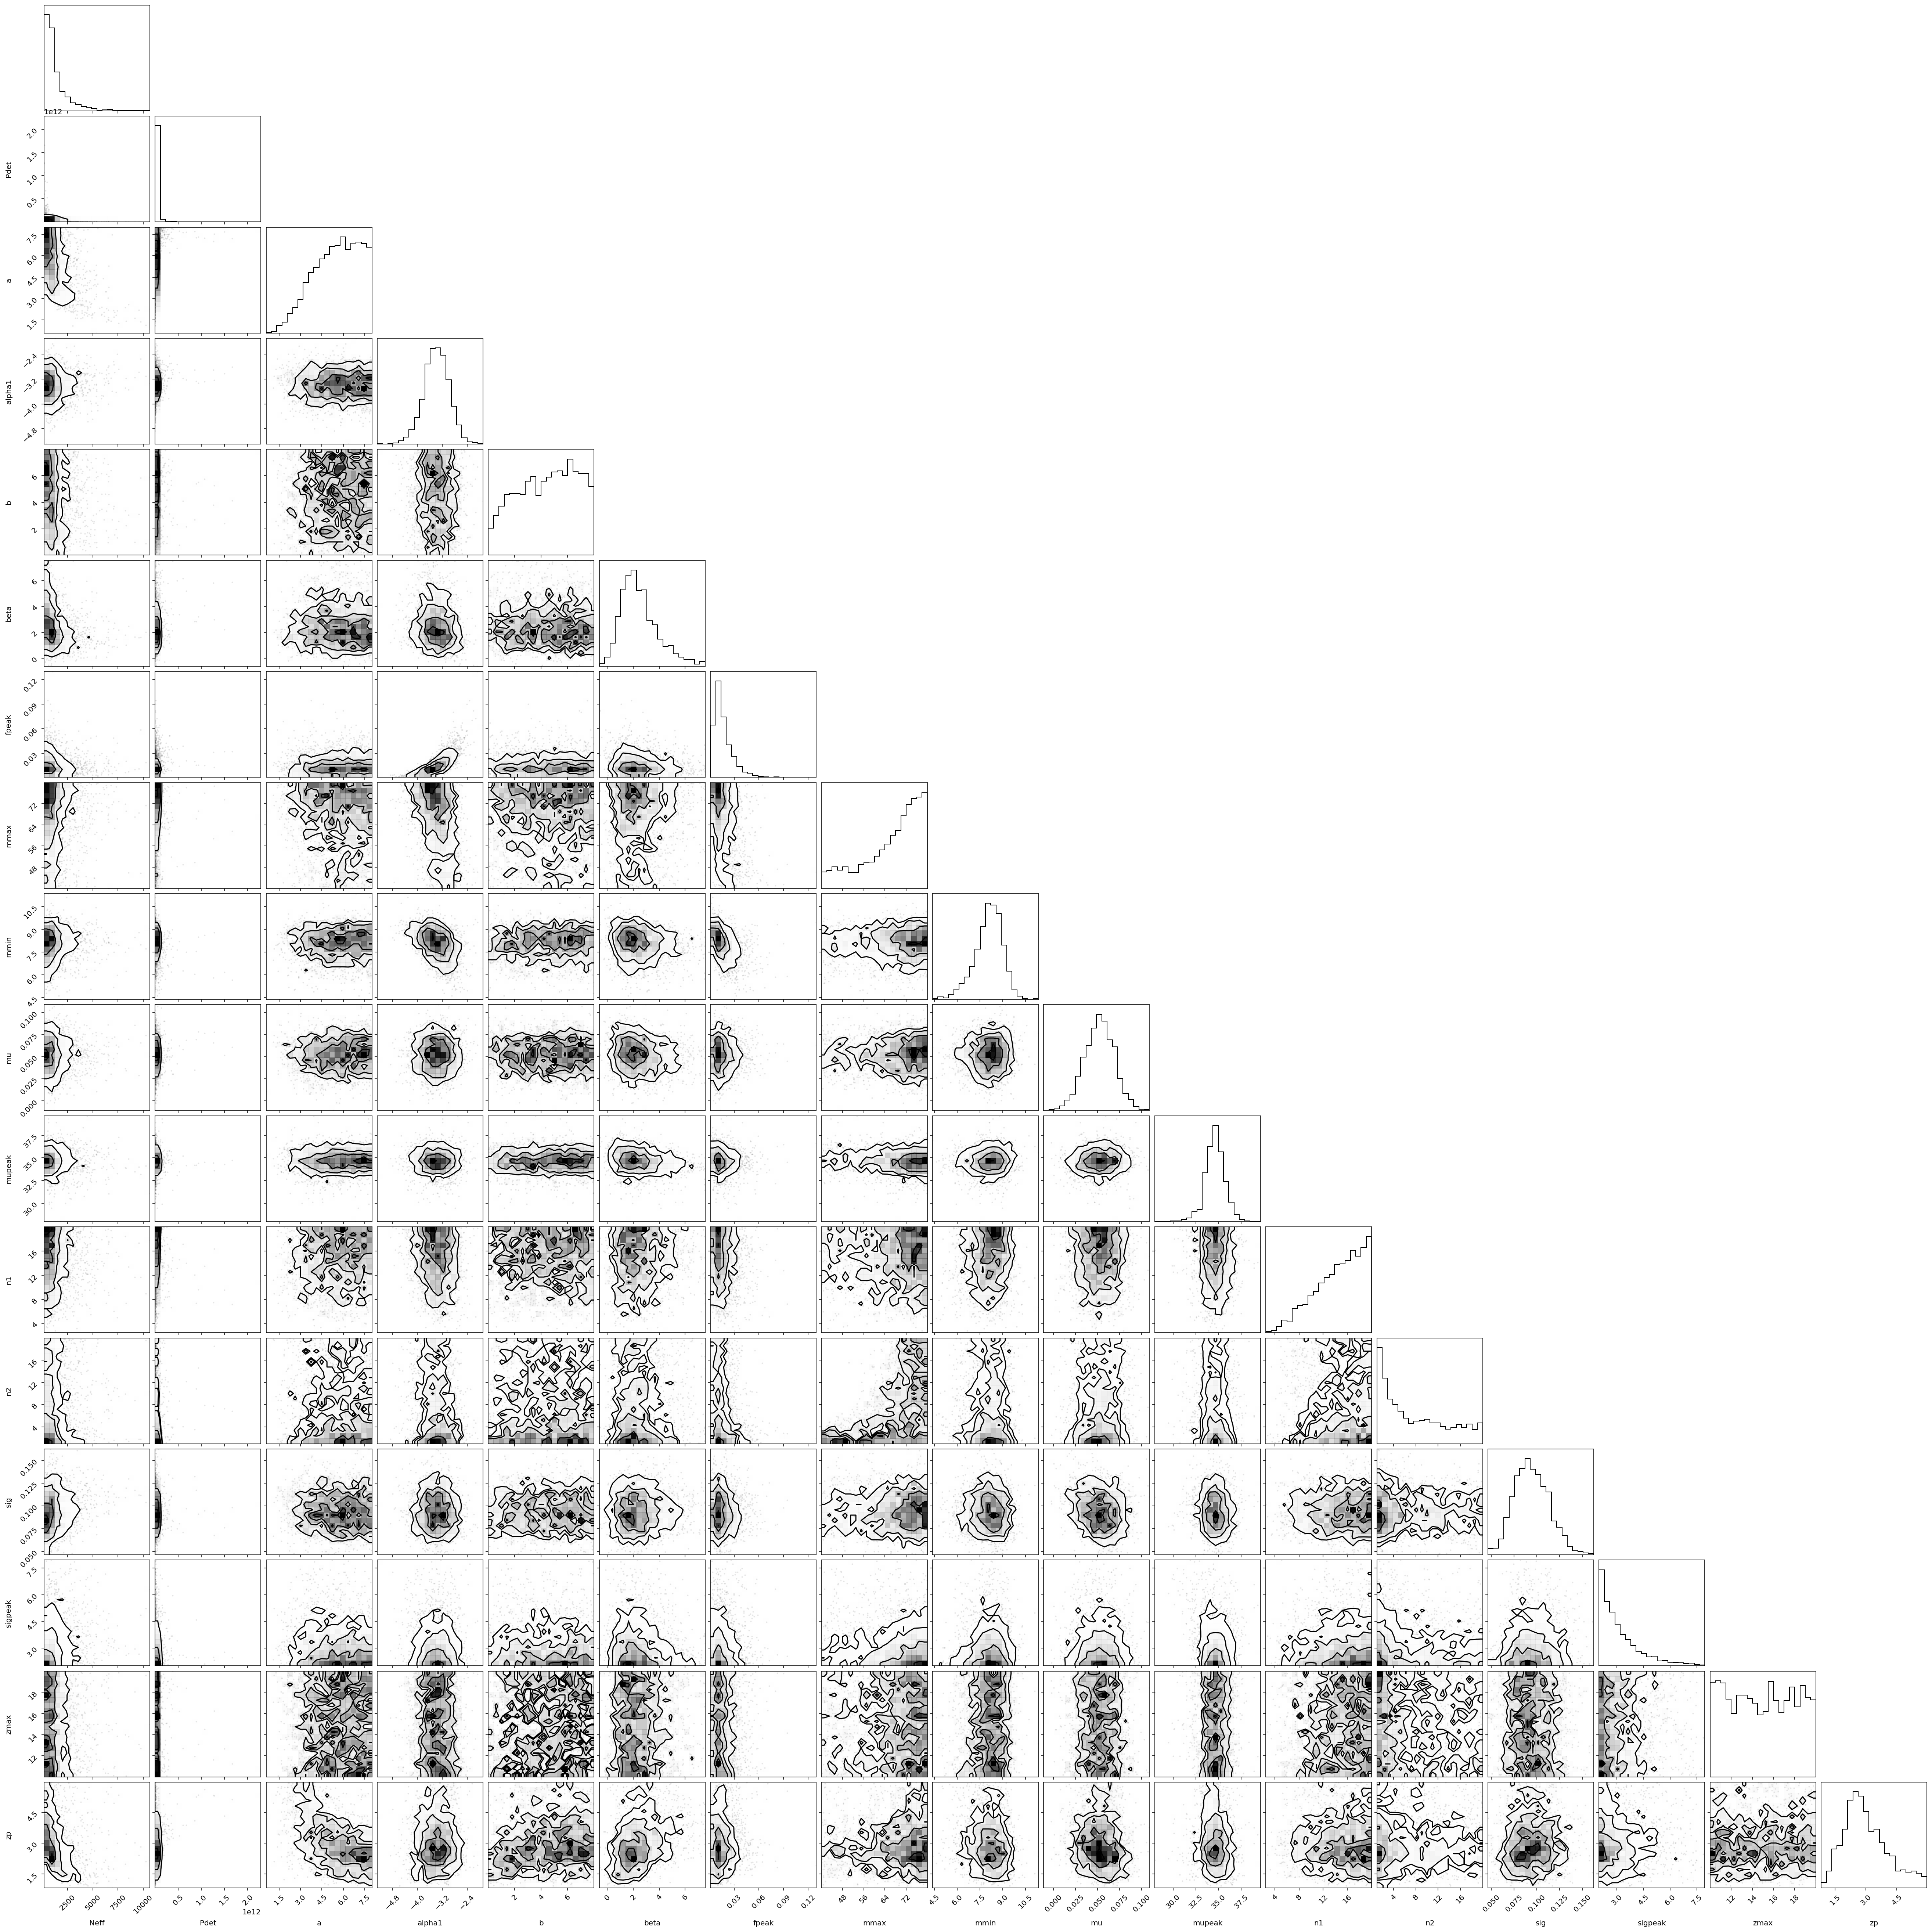

In [19]:
corner.corner(samples);

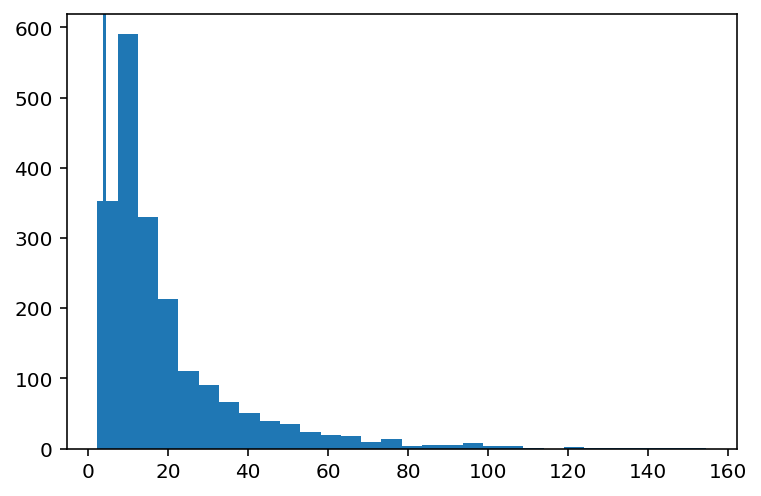

In [21]:
plt.hist(samples['Neff']/69, bins = 30)
plt.axvline(4)